In [14]:
from __future__ import print_function
from bs4 import BeautifulSoup as bs
from colour import Color
from corextopic import corextopic as ct
from gensim.corpora import Dictionary
from gensim.models import doc2vec
from gensim.models.coherencemodel import CoherenceModel
from htmlparsing_kit import *
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.util import everygrams
from nordvpn_switcher import initialize_VPN,rotate_VPN,terminate_VPN
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle
from stop_words import get_stop_words
from string import digits
from tqdm import tqdm
from webscraping_kit import read_jsoncsv, read_htmlfile, read_htmlresponse, read_driverresponse, get_cases
from webscraping_kit import write_htmlfile, write_json_tofile, write_driverhtmlfile, rmnl
from htmlparsing_kit import clean_sections
import matplotlib.pyplot as plt
import multiprocessing as mp
from selenium import webdriver
import numpy as np
import pandas as pd
import re, os, glob, csv, math, requests, time, sys, random, json, datetime, urllib, nltk, pickle
import scipy.sparse as ss
from scipy import spatial
%matplotlib inline


def create_anchors(words):
    rent = ['rent reduction','reduction rent','reduce rent','reduced rent','rent reduce',
            'rent increase','increase rent', 'raise rent','decrease rent','refund rent','rebate',
            "guideline increase","above guideline",'exempt', 'exemption',
            't4','t3','t1','a4','t7', 'a1','act applies','n1','n2','n3','n10','l5',
            '104','111','112','120','1201','121','1211','122','126','127','129','131', '132','133','165','167',
            'municipal tax','municipal taxes','capital expenditures','capital expenditure','capital expense', 
            'vary percentage','vary rent reduction','vary amount',
            'above guideline','guideline increase','above increase', "increase above",'lawful rent','notice rent','rent charge','rent charged',
            '110','113','114','116','117','118','123','124','125','128','129','130','134','135','1351','136', 
            '1191','1192','149','150','151','165','1651','166','167',
            'collected money illegally','retain money illegally','money illegally',
            'collect retain','collected retained','retained money illegally','retained illegally']
    faith = ['bad faith','good faith','termin bad','termination bad','notice termination bad',
             'termin faith','termination faith','termination bad faith', 
             't5','n12','n13','purpose residential','purposes residential','residential occupation',
             'demolish', 'renovation', 'renovate','renovation complete','renovations', 
             '48','481','49','491','50','51', '52','53','54','55', '551','56','57','571','58', 
             'first refusal', 'convert','purchase sale','purchaser requires','purchaser require','require unit purpose', 
             'right first refusal','right first refuse','require unit','compensation']
    interfere = ['233','234','235','236','237','238','239','240','881','60','61','62','63', '64','65','66','67','68','137','138',
                 'reasonable enjoyment','harrass','obstruct','coerce','maintenance obligations','maintenance obligation','maintenance',
                 'vital service','interfere','interfered', 'enter unit illegally','entered unit illegally','locking system',
                 'replacement keys','illegal act','illegal acts','t6','meet obligation','damage',
                 'harrass obstruct','obligations','deliberately interfered','deliberately interfere',
                 'unauthorized occupant','someone permitted','tenant permitted','enter complex','lawful right',
                 'n5','n6','n7','l8']
    nonpayment = ['l1','l2','l4','l9','l10','l1l9','pay rent tenant','rent tenant owe','pay rent','evict','arrears','pay rent','59','74','74','7411']
    anchorlist = [[x for x in rent if x in words],[x for x in faith if x in words],[x for x in interfere if x in words],[x for x in nonpayment if x in words]]
    return anchorlist

        
def optimize_params(docs,ngramranges,maxdflist,maxfeatures,anchorstrengths,applicanttype):
    itercounter = 0
    results = []
    for anchorstrength in anchorstrengths:
        print('-------------------------------------------------')
        print("            Anchor strength: "+ str(anchorstrength))
        print('-------------------------------------------------')
        for nr in ngramranges:
            print('-------------------------------------------------')
            print("         Ngram range: "+ ','.join([str(x) for x in nr]))
            print('-------------------------------------------------')
            for mx in maxdflist:
                print('           -------------------------             ')
                print("             Max Document Frequency:             "+ str(mx))
                print('           -------------------------             ')
                for fc in maxfeatures:
                    print("Max Features: "+str(fc))
                    vectorizern = TfidfVectorizer(ngram_range=(nr[0], nr[1]), max_features = fc, max_df = mx, min_df = 0.01)
                    dtm_tf = vectorizern.fit_transform(docs)
                    dtm_tf = ss.csr_matrix(dtm_tf)
                    words = vectorizern.get_feature_names_out()
                    anchorlist = create_anchors(words)
                    anchorstring = ','.join(anchorlist[0]) + '|' + ','.join(anchorlist[1])  + '|' + ','.join(anchorlist[2])  + '|' + ','.join(anchorlist[3])
                    print(anchorstring)
                    for T in T_list:
                        print("Topic count: "+str(T))
                        topic_model = ct.Corex(n_hidden=T)
                        topic_model.fit(dtm_tf, words=words, docs=docs, anchors = anchorlist,anchor_strength=anchorstrength)
                        topicstc = topic_model.tc
                        results.append(['_'.join([str(x) for x in nr]),mx,fc,T,topicstc,anchorstring,anchorstrength])
                        itercounter +=1
                        print(topicstc)
                    print(anchorstring)
                print(itercounter)
        print('--------------------------------------------------')
    rdf = pd.DataFrame(results,columns=['ngramrange','maxdf','maxfeatures','topiccount','totalcorrelation','anchors','anchorstrength'])
    rdf['applicant'] = applicanttype
    return rdf

def gettopicwords(topic_model,words):
    topicstrings = []
    topics = topic_model.get_topics()
    for topic_n,topic in enumerate(topics):
        # w: word, mi: mutual information, s: sign
        topic = [(w,mi,s) if s > 0 else ('~'+w,mi,s) for w,mi,s in topic]
        words,mis,signs = zip(*topic)    
        topic_str = str(topic_n+1)+': '+', '.join(words)
        print(topic_str)
        topicstrings.append(topic_str)
    return topicstrings

def get_doctopics(dtafrme,topic_model,applicant,numtopics,yeargroup):
    topicdf = pd.DataFrame(topic_model.p_y_given_x)
    topicdf.columns = list(range(0,numtopics))
    topicdf['cid'] = dtafrme['cid'].tolist()
    topicdf.to_csv(mainpath + 'output/5_corextopics_'+ str(applicant)+'_'+yeargroup.split(',')[0].strip()+'.csv',sep='\t',index=False,quoting=csv.QUOTE_ALL)
    del topicdf['cid']
    topicdf = topicdf.idxmax(axis=1).reset_index()
    del topicdf['index']
    topicdf.columns = ['topic']
    topicdf['cid'] = dtafrme['cid'].tolist()
    dtafrme = dtafrme.copy()
    dtafrme['topic'] = dtafrme['cid'].map(dict(zip(topicdf['cid'],topicdf['topic'])))
    dtafrme.fillna('',inplace=True)
    return dtafrme

def get_doctopics2(dtafrme,topic_model,applicant,numtopics):
    topicdf = pd.DataFrame(topic_model.p_y_given_x)
    topicdf.columns = list(range(0,numtopics))
    topicdf['cid'] = dtafrme['cid'].tolist()
    topicdf.to_csv(mainpath + 'output/6_corextopics_'+ str(applicant)+'.csv',sep='\t',index=False,quoting=csv.QUOTE_ALL)
    del topicdf['cid']
    topicdf = topicdf.idxmax(axis=1).reset_index()
    del topicdf['index']
    topicdf.columns = ['topic']
    topicdf['cid'] = dtafrme['cid'].tolist()
    dtafrme = dtafrme.copy()
    dtafrme['topic'] = dtafrme['cid'].map(dict(zip(topicdf['cid'],topicdf['topic'])))
    dtafrme.fillna('',inplace=True)
    return dtafrme

def createmodel(docs,ngramrange,maxf,maxdf,numtopics,anchorstrength):
    vectorizer = TfidfVectorizer(ngram_range=(ngramrange[0],ngramrange[1]), max_features = maxf, max_df = maxdf, min_df = 0.01)
    dtm_tf = vectorizer.fit_transform(docs)
    dtm_tf = ss.csr_matrix(dtm_tf)
    words = vectorizer.get_feature_names_out()
    anchorlist = create_anchors(words)
    anchorstring = ','.join(anchorlist[0]) + '|' + ','.join(anchorlist[1])  + '|' + ','.join(anchorlist[2])  + '|' + ','.join(anchorlist[3])
    print(anchorstring)
    topic_model = ct.Corex(n_hidden=numtopics)
    topic_model.fit(dtm_tf, words=words, docs=docs, anchors = anchorlist, anchor_strength=anchorstrength)
    print(topic_model.tc)
    topicstrings = gettopicwords(topic_model,words)
    # print(topicstrings)
    return topic_model,vectorizer,dtm_tf,words,anchorstring,topicstrings


In [2]:
mainpath = str(os.getcwd())+'/'
df = pd.read_csv(mainpath+"output/5_model_results.csv",sep='\t')
print(df.shape)
df['cleansections']=df['sections'].apply(lambda x: clean_sections(x))
df['datetime'] = pd.to_datetime(df['date'])
df['year'] = df['datetime'].dt.year

yeargroupdict = {2006:"2006,2007,2008,2009,2010,2011", 2007:"2006,2007,2008,2009,2010,2011", 2008:"2006,2007,2008,2009,2010,2011", 2009:"2006,2007,2008,2009,2010,2011", 2010:"2006,2007,2008,2009,2010,2011", 2011:"2006,2007,2008,2009,2010,2011", 2012:"2012,2013,2014,2015", 2013:"2012,2013,2014,2015", 2014:"2012,2013,2014,2015", 2015:"2012,2013,2014,2015", 2016:"2016,2017,2018,2019", 2017:"2016,2017,2018,2019", 2018:"2016,2017,2018,2019", 2019:"2016,2017,2018,2019", 2020:"2020,2021", 2021:"2020,2021"}

df['yeargroup'] = df['year'].map(yeargroupdict)

(36461, 35)


In [3]:
print(df['yeargroup'].value_counts())

2020,2021                        17744
2016,2017,2018,2019               7407
2012,2013,2014,2015               5843
2006,2007,2008,2009,2010,2011     5467
Name: yeargroup, dtype: int64


In [4]:
print(df[['yeargroup','applicant']].value_counts())

yeargroup                      applicant
2020,2021                      0            17320
2016,2017,2018,2019            0             5137
2012,2013,2014,2015            0             4159
2006,2007,2008,2009,2010,2011  0             3985
2016,2017,2018,2019            1             2270
2012,2013,2014,2015            1             1684
2006,2007,2008,2009,2010,2011  1             1482
2020,2021                      1              424
dtype: int64


In [5]:
T_list = [5,10,15]
maxfeatures = [5000,6000,7000] # 9000 for tt; <=8000 for ll
maxdflist = [0.75,0.8,0.85]
ngramranges = [[1,3],[1,4]]
anchorstrengths = [2,3]
print(len(T_list)*len(maxfeatures)*len(maxdflist)*len(ngramranges)*len(anchorstrengths))

108


<h3> Parameter optimization </h3>

In [ ]:
# yeartestsframes = []
# for i,(n,yg) in enumerate(df.groupby("yeargroup")):
#     print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
#     print('                                      Yeargroup: '+n)
#     print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
#     tdf = yg[yg['applicant']==1]
#     tdocs = tdf.topiccleantext
#     ldf = yg[yg['applicant']==0]
#     ldocs = ldf.topiccleantext
#     ttopics = optimize_params(tdocs,ngramranges,maxdflist,maxfeatures,anchorstrengths,1)
#     ttopics['yeargroup'] = ','.join([str(x) for x in sorted(list(set(yg['year'].tolist())))])
#     ttopics['applicant'] = 1
#     ttopics['bestparams'] = np.where(ttopics['totalcorrelation']==ttopics['totalcorrelation'].max(), 'best','other')
#     llopics = optimize_params(ldocs,ngramranges,maxdflist,maxfeatures,anchorstrengths,0)
#     llopics['yeargroup'] = ','.join([str(x) for x in sorted(list(set(yg['year'].tolist())))])
#     llopics['applicant'] = 0
#     llopics['bestparams'] = np.where(llopics['totalcorrelation']==llopics['totalcorrelation'].max(), 'best','other')
#     yeartestsframes.append(ttopics)
#     yeartestsframes.append(llopics)

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
                                      Yeargroup: 2006,2007,2008,2009,2010,2011
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
-------------------------------------------------
            Anchor strength: 2
-------------------------------------------------
-------------------------------------------------
         Ngram range: 1,3
-------------------------------------------------
           -------------------------             
             Max Document Frequency:             0.75
           -------------------------             
Max Features: 5000
rent reduction,reduction rent,reduce rent,rent increase,increase rent,refund rent,rebate,exempt,exemption,t3,t1,act applies,lawful rent,notice rent,rent charge,135,retain money illegally,money illegally,collect retain,retained money illegally|termination bad,notice termination bad,n12,purpose res

In [ ]:
# topictestsdf = pd.concat(yeartestsframes)

In [ ]:
# topictestsdf.to_csv(mainpath + 'output/6_corex_paramopt_yeargroup.csv',sep='\t',index=False,quoting=csv.QUOTE_ALL)

<h3> Test on full dataframe </h3>

In [6]:
tdf = df[df['applicant']==1]
tdocs = tdf.topiccleantext
ldf = df[df['applicant']==0]
ldocs = ldf.topiccleantext
ttopics = optimize_params(tdocs,ngramranges,maxdflist,maxfeatures,anchorstrengths,1)
ttopics['applicant'] = 1
ttopics['bestparams'] = np.where(ttopics['totalcorrelation']==ttopics['totalcorrelation'].max(), 'best','other')
llopics = optimize_params(ldocs,ngramranges,maxdflist,maxfeatures,anchorstrengths,0)
llopics['applicant'] = 0
llopics['bestparams'] = np.where(llopics['totalcorrelation']==llopics['totalcorrelation'].max(), 'best','other')

-------------------------------------------------
            Anchor strength: 2
-------------------------------------------------
-------------------------------------------------
         Ngram range: 1,3
-------------------------------------------------
           -------------------------             
             Max Document Frequency:             0.75
           -------------------------             
Max Features: 5000
rent reduction,reduction rent,rent increase,increase rent,refund rent,rebate,exempt,exemption,t3,t1,act applies,lawful rent,notice rent,rent charge,116,135,retain money illegally,money illegally,collect retain,retained money illegally|termination bad,notice termination bad,t5,n12,purpose residential,residential occupation,demolish,renovation,renovate,48,481,49,51,52,53,54,55,57,571,58,convert,compensation|60,61,63,64,66,67,68,reasonable enjoyment,obstruct,coerce,interfere,interfered,enter unit illegally,t6,meet obligation,damage,deliberately interfere,lawful right

In [580]:
full_topictestsdf = pd.concat([ttopics,llopics])
full_topictestsdf[full_topictestsdf['bestparams']=='best']

,ngramrange,maxdf,maxfeatures,topiccount,totalcorrelation,anchors,anchorstrength,applicant,bestparams
89,1_4,0.75,7000,15,2.686130,"rent reduction,reduction rent,reduce rent,rent...",3,1,best
104,1_4,0.85,6000,15,8.545561,"rent increase,increase rent,lawful rent,notice...",3,0,best


In [581]:
full_topictestsdf.to_csv(mainpath + 'output/6_corex_paramopt.csv',sep='\t',index=False,quoting=csv.QUOTE_ALL)

In [9]:
full_bestparamdf = full_topictestsdf[full_topictestsdf['bestparams']=='best']

In [10]:
paramdict = {}

for n, g in full_bestparamdf.groupby(["applicant"]):
    g = g.copy()
    if n ==1:
        paramdict[n] = {"ngramrange":sorted([int(x) for x in g['ngramrange'].tolist()[0].split('_')]),"maxdf":g['maxdf'].tolist()[0],"maxfeatures":g['maxfeatures'].tolist()[0],"topiccount":g['topiccount'].tolist()[0],"anchorstrength":g['anchorstrength'].tolist()[0],"anchors":[x.split(',') for x in g['anchors'].tolist()[0].split('|')]}
    else:
        paramdict[n] = {"ngramrange":sorted([int(x) for x in g['ngramrange'].tolist()[0].split('_')]),"maxdf":g['maxdf'].tolist()[0],"maxfeatures":g['maxfeatures'].tolist()[0],"topiccount":g['topiccount'].tolist()[0],"anchorstrength":g['anchorstrength'].tolist()[0],"anchors":[x.split(',') for x in g['anchors'].tolist()[0].split('|')]}
        continue

In [11]:
print(paramdict)

{0: {'ngramrange': [1, 4], 'maxdf': 0.85, 'maxfeatures': 6000, 'topiccount': 15, 'anchorstrength': 3, 'anchors': [['rent increase', 'increase rent', 'lawful rent', 'notice rent', 'rent charge'], ['n12', 'purpose residential', 'residential occupation', 'renovation', '48', '481', 'compensation'], ['60', '64', '68', 'reasonable enjoyment', 'obstruct', 'interfere', 'interfered', 'illegal act', 'damage', 'lawful right', 'n5', 'n6', 'n7'], ['l1', 'l2', 'l4', 'l9', 'pay rent tenant', 'rent tenant owe', 'pay rent', 'arrears', 'pay rent', '7411']]}, 1: {'ngramrange': [1, 4], 'maxdf': 0.75, 'maxfeatures': 7000, 'topiccount': 15, 'anchorstrength': 3, 'anchors': [['rent reduction', 'reduction rent', 'reduce rent', 'rent reduce', 'rent increase', 'increase rent', 'raise rent', 'refund rent', 'rebate', 'exempt', 'exemption', 't3', 't1', 'act applies', '120', 'lawful rent', 'notice rent', 'rent charge', '116', '134', '135', 'retain money illegally', 'money illegally', 'collect retain', 'retained mone

In [16]:
dfytt = df[df['applicant']==1]
tt_params = paramdict[1]
tt_docs = dfytt['topiccleantext'].tolist()
tt_vectorizer = TfidfVectorizer(ngram_range=(tt_params['ngramrange'][0],tt_params['ngramrange'][1]), max_features = tt_params['maxfeatures'], max_df = tt_params['maxdf'], min_df = 0.01)
tt_dtm_tf = tt_vectorizer.fit_transform(tt_docs)
tt_dtm_tf = ss.csr_matrix(tt_dtm_tf)
tt_words = tt_vectorizer.get_feature_names_out()
tt_topic_model = ct.Corex(n_hidden=tt_params['topiccount'])
tt_topic_model.fit(tt_dtm_tf, words=tt_words, docs=tt_docs, anchors = tt_params['anchors'], anchor_strength=tt_params['anchorstrength'])
tt_topicstrings = gettopicwords(tt_topic_model,tt_words)
dfytt = get_doctopics2(dfytt,tt_topic_model,1,tt_params['topiccount'])
topicdescdict_tt = {}
for ts in tt_topicstrings:
    k = int(ts.split(':',1)[0].strip())-1
    topicdescdict_tt[k] = ts
dfytt['topicdesc'] = dfytt['topic'].map(topicdescdict_tt)
dfytt['tc'] = tt_topic_model.tc
# dfytt['tcs'] = tt_topic_model.tcs
with open(mainpath +'models/corex/corexmodel_tt.pkl', 'wb') as f:
    pickle.dump((tt_vectorizer, tt_topic_model), f)


1: rent increase, increase, notice rent, 116, increase rent, notice rent increase, lawful rent, rent charge, 31 act, raise rent
2: n12, termination bad, notice termination bad, 57, bad, t5, n12 notice, 571, give notice termination, notice termination
3: t6, repair, leak, mould, standard, damage, obligation, meet landlord obligation, meet landlord, landlord obligation
4: review, request review, serious error, error, sppa, serious, review request, error occur, serious error occur, error serious error
5: supply, vital, reasonable supply, supply vital, reasonable supply vital, interfere reasonable supply, interfere reasonable supply vital, deliberately interfere reasonable supply, deliberately interfere reasonable, supply tenancy
6: 12 landlord, rental unit locate, rental unit period, rental unit request, rental unit satisfy, requirement act, reserve, rental unit 15, respect application, t2 application application
7: lock, give entry, door give entry, give entry rental, give entry rental u

Text(0, 0.5, 'Total Correlation (nats)')

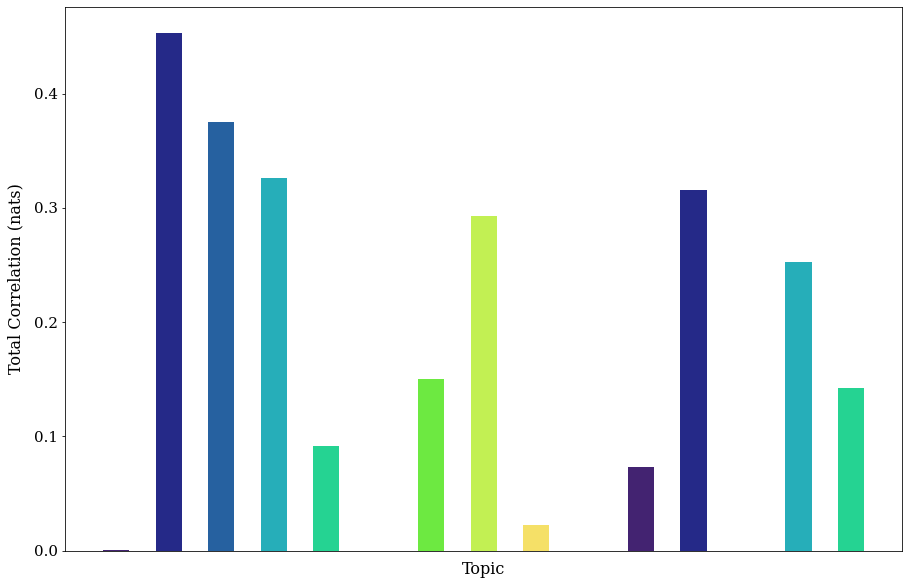

In [17]:
startcolor = Color("#432371")
endcolor = Color("#FAAE7B")
colors = [str(x) for x in list(startcolor.range_to(endcolor,10))]
# anchorlistnames =list(keytopics.keys())
plt.figure(figsize=(15,10))
plt.bar(list(range(0,tt_params['topiccount'])), tt_topic_model.tcs, color=colors, width=0.5)
plt.xticks([])

# plt.xticks(rotation = 90)
plt.xlabel('Topic', fontsize=16,labelpad=10)
plt.ylabel('Total Correlation (nats)', fontsize=16,labelpad=10)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 16
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
# plt.legend(handles=[mpatches.Patch(color=v, label=k) for k,v in dict(zip(anchorlistnames+['Other'],colors)).items()],title="Topic", fontsize=16, fancybox=True,bbox_to_anchor=(1, 1))
plt.yticks(rotation = 0,fontsize=15,fontname='serif')
plt.xticks(rotation = 45,fontsize=15,fontname='serif')
plt.xlabel('Topic', fontsize=16,labelpad=10,fontname='serif')
plt.ylabel('Total Correlation (nats)', fontsize=16,labelpad=10,fontname='serif')
# plt.savefig(mainpath + 'graphs/tt_corextopics_tc.png', dpi=600, bbox_inches='tight')

In [18]:
dfyll = df[df['applicant']==0]
ll_params = paramdict[0]
ll_docs = dfyll['topiccleantext'].tolist()
ll_vectorizer = TfidfVectorizer(ngram_range=(ll_params['ngramrange'][0],ll_params['ngramrange'][1]), max_features = ll_params['maxfeatures'], max_df = ll_params['maxdf'], min_df = 0.01)
ll_dtm_tf = ll_vectorizer.fit_transform(ll_docs)
ll_dtm_tf = ss.csr_matrix(ll_dtm_tf)
ll_words = ll_vectorizer.get_feature_names_out()
ll_topic_model = ct.Corex(n_hidden=ll_params['topiccount'])
ll_topic_model.fit(ll_dtm_tf, words=ll_words, docs=ll_docs, anchors = ll_params['anchors'], anchor_strength=ll_params['anchorstrength'])
ll_topicstrings = gettopicwords(ll_topic_model,ll_words)
dfyll = get_doctopics2(dfyll,ll_topic_model,0,ll_params['topiccount'])
topicdescdict_ll = {}
for ts in ll_topicstrings:
    k = int(ts.split(':',1)[0].strip())-1
    topicdescdict_ll[k] = ts
dfyll['topicdesc'] = dfyll['topic'].map(topicdescdict_ll)
dfyll['tc'] = ll_topic_model.tc
# dfyll['tcs'] = ll_topic_model.tcs
with open(mainpath +'models/corex/corexmodel_ll.pkl', 'wb') as f:
    pickle.dump((ll_vectorizer, ll_topic_model), f)


1: condition specify, specify, request payment arrears rent, request payment arrears, request payment, previous, previous application, condition, payment arrears rent, cost related
2: pay landlord, landlord, landlord enforcement eviction enforce, landlord enforcement eviction, landlord enforcement, shall also pay landlord, also pay landlord, landlord apply, pay landlord full amount, landlord full amount
3: damage, n5, interfere, reasonable enjoyment, lawful right, illegal act, review, another, n7, another rental unit
4: 7411, arrears, ~l1, ~l2, l4, ~l9, pay rent, pay rent tenant, rent tenant owe
5: possession rental unit shall, termination effective vacate rental, termination effective vacate, notice termination effective vacate, effective vacate rental, effective vacate rental unit, rental unit possession rental, give possession rental, give possession rental unit, unit possession rental
6: 2041, condition set, fails make, 78, day breach, fails, fails make payment, arrears arrears, sh

In [606]:
landlords = {0: "Failed Condition",1:"Compensation for Landlords",2:"Interference",3:"Nonpayment/Agreement/Good Faith",4:"Nonpayment",5:"Nonpayment",6:"Nonpayment",7:"Good Faith/Agreement/Nonpayment",8:"Agreement",9:"Failed Condition",10:"Good Faith/Nonpayment",11:"Nonpayment",12:"Nonpayment",13:"Nonpayment",14:"Nonpayment"}
# 1. i.e. tenants remaining in unit after eviction date, having not paid in full already
# 8. whether came to an agreement before, during hearing (e.g. consent)
tenants = {0: "Rent Control",1:"Bad Faith",2:"Interference",3:"Interfere/Rent Control",4:"Interfere/Rent Control",5:"Interference/Act Applies",6:"Interference",7:"Rent Control",8:"Interference",9:"No Documents",10:"Rent Control/Interference",11:"Interference",12:"Interference",13:"Interfere/Rent Control",14:"Interference"}
# 1. also act applies
# 7. also mainlt retain money illegally
dfytt['topicname'] = dfytt['topic'].map(tenants)
dfyll['topicname'] = dfyll['topic'].map(landlords)
ydf = pd.concat([dfytt,dfyll])
print(ydf['topicname'].value_counts())

Nonpayment                         15091
Interference                        8139
Good Faith/Nonpayment               3432
Failed Condition                    3362
Agreement                           1743
Interfere/Rent Control              1574
Compensation for Landlords          1268
Nonpayment/Agreement/Good Faith     1054
Rent Control                         299
Bad Faith                            296
Good Faith/Agreement/Nonpayment      105
Rent Control/Interference             88
Interference/Act Applies              10
Name: topicname, dtype: int64


In [607]:
ydf.to_csv(mainpath + 'output/6_case_db.csv',sep='\t',index=False,quoting=csv.QUOTE_ALL)

In [608]:

# ydf[ydf['topicname']=='']

In [609]:
# dfytt['topic'].value_counts()

In [610]:
# topicnum = 3
# for n, g in ydf.groupby(['applicant']):
#     print('>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
#     print(g[g['topic']==topicnum].shape[0])
#     if n == 1:
#         print("                    TENANTS  topic: "+str(topicnum))
#         print()
#         print(random.sample(g[g['topic']==topicnum]['topiccleantext'].tolist(),1)[0][:1000])
#         print('----------------------------------------------------------')
#     else:
#         print("                    LANDLORDS  topic: "+str(topicnum))
#         print()
#         print(random.sample(g[g['topic']==topicnum]['topiccleantext'].tolist(),1)[0][:1000])
#         print('----------------------------------------------------------')
#         continue

In [ ]:
# landlords = {0: "Failed Condition",1:"Compensation for Landlords",2:"Interference",3:"Nonpayment/Agreement/Good Faith",4:"Nonpayment",5:"Nonpayment",6:"Nonpayment",7:"Good Faith/Agreement/Nonpayment",8:"Agreement",9:"Failed Condition",10:"Good Faith/Nonpayment",11:"Nonpayment",12:"Nonpayment",13:"Nonpayment",14:"Nonpayment"}
# # 1. i.e. tenants remaining in unit after eviction date, having not paid in full already
# # 8. whether came to an agreement before, during hearing (e.g. consent)
# tenants = {0: "Rent Control",1:"Bad Faith",2:"Interference",3:"Interfere/Rent Control",4:"Interfere/Rent Control",5:"Interference/Act Applies",6:"Interference",7:"Rent Control",8:"Interference",9:"No Documents",10:"Rent Control/Interference",11:"Interference",12:"Interference",13:"Interfere/Rent Control",14:"Interference"}
# # 1. also act applies
# # 7. also mainlt retain money illegally

In [ ]:
"""
https://arxiv.org/pdf/1611.10277.pdf
https://proceedings.neurips.cc/paper/2014/file/4f6ffe13a5d75b2d6a3923922b3922e5-Paper.pdf
https://ryanjgallagher.github.io/files/slides/gallagher2017anchored_naccl2018.pdf

                                              COREX

1. find prob(word) in a document for each word in document: count_OR_tfidf(word) / sum(# of words in vocabulary)
2. find joint probability of each pair of words in a document: prob(word1,wordi) = prob(word1) X prob(wordi)  (from i-N words in doc)
   e.g. vocab = [x1,x2,x3,x4,x5], doc1 = [x1,x2] (1,1,0,0,0), doc2 = [x3,x4] (0,0,1,1,0)
   - prob(x1=0,x2=0) = 1/2 (docs)
   - prob(x1=1,x2=1) = 1/2 (docs)
   - prob(x1=1,x2=0) = 0/2 (docs)
   - prob(x1=0,x2=1) = 0/2 (docs)
3. using mutual info (but also probs above), can see x1 and x2 related, but goal is to find a latent factor Y, that makes x1 and x2 conditionally independent:
   - D_KL(pr(x1,x2|y1)||p(x1|y1)p(x2|y1)) = 0 
   - otherwise:
   -- D_KL(pr(x1,x2)||p(x1)p(x2)) = 1 (related)
4. use for all documents:

  minY D_KL( p(x1,x2,...,xn | y) || TT_i( p(xi | y) ) )
  - want to minimize TC conditioned on latent factor y, so TC( X | Y ) = 0 if and only if the topic/grouping explains all dependencies; e.g. as above

5. info bottleneck: 
  - compute sum of: total correlation for each document, and for each topic/group of words
  -- (TC for that group/topic (y) of words (x))  - 

  - idea is that each grouping of words in a document, can be explained by a particular grouping of documents, and the difference between TC of the grouping of words between groupings of documents is used to decide the groups/topics
  
  - can add anchor words to the latent topics by modifying the weight of the relationship between a word and a topic
"""

# Whereas equal sign indicates the right side value is equal to left side value. Triple bar means the two things on both sides are equivalent in all aspects (entropy of word/s should be  =(equivalent to)).
# - group words into subsets, then calculate the entroy by group

# probability of a word (in a document)*:                  prob(word)        = count(word) / sum(# of words in vocabulary)

# joint probability of 2 words (independent)*:             prob(word1,word2) = prob(word1) X prob(word2)

# conditional probability of 2 words (dependent)*:         prob(word2|word1) = prob(word2) * prob(word1|word2)

# bayes theorem with 2 words (dependent)*:                 prob(word2|word1) = (prob(word2) * prob(word1|word2)) / prob(word1)


# entropy of word:                                        H(word) = E_x[-log(prob(x))] ..... 
#                                                                 = -(prob(word))*log_2(prob(word))

# entropy of 2 words:                                     H(word1, word2) = - (prob(word1,word2)) * log_2(prob(word1,word2))

# mutual info 2 words:                                    I(word1 : word2) = H(word1) + H(word2) - H(word1,word2)

# info gain:                                              IG(word2,word1) = H(word2) - H(word2|word1)

# Total correlation is a functional over the joint distribution, p(x, y) = p(y|x)p(x), so the optimization implicitly depends on the data through p(x)